# Calculate the (rt) transfer function for a compressive wave through a sample stellar atmosphere 

Words of **caution** to future Momo:

    -- units for different quantities: 
               -- cmass : g/cm^2
               -- Temperature : K 
               -- Velocity: km/s
               -- Ne: cm^{-3}
               
    -- Positive velocity in the input means velocity towards the observer in [km/s]. 

In [1]:
import numpy as np
import scipy as sp 
import matplotlib as mp
import matplotlib.pyplot as plt
import astropy.io.fits as fits

from scipy import interpolate as interpolate
from scipy import optimize as optimize
from scipy import integrate as integrate

from RHlib import *

In [2]:
## Global constants 

c  = 3e5 

In [20]:
class Atmos_height():
    ''' Class to hold all the atmospheric info
    numpy.interp(x, xp, fp,...)'''
    
    def __init__(self,fileName,Nx_num_new):
        
        
        atmos_temp   = (np.loadtxt(fileName)).transpose()
        nH_temp      = (np.loadtxt(fileName+'_pops')).transpose()
        self.cs      = 7 
        
        self.Nx_num_new      = Nx_num_new
        self.Nx_num_original = (atmos_temp.shape)[1]

        self.Nx      = list(range(self.Nx_num_original))
        self.Nx_new  = list(range(Nx_num_new))
        
        height_new   = np.linspace(atmos_temp[0,-1],
                                   atmos_temp[0,0], num=self.Nx_num_new)
        
        self.height  = height_new
        h            = np.flip(atmos_temp[0,:])
        
        self.H_levels   = 6
        self.model_name = fileName

        self.T          = np.interp(height_new, h, 
                                     np.flip(atmos_temp[1,:]))
        #print(atmos_temp[0,:])
        #print(atmos_temp[1,:])
        #print(height_new)
        #
        #plt.figure(figsize=(10,8))
        #plt.plot(self.height,self.T,'y.',label='Interpolated Temperature')
        #plt.plot(h,atmos_temp[1,:],'b--',label='initial Temperature')
        #plt.legend()
        #plt.show()
        #
        
        self.Ne          = np.interp(height_new, h, 
                                     np.flip(atmos_temp[2,:]))
        self.V           = np.interp(height_new, h, 
                                     np.flip(atmos_temp[3,:]))
        self.Vturb       = np.interp(height_new, h, 
                                     np.flip(atmos_temp[4,:]))
        self.B           = np.zeros(self.Nx_num_new)
        self.phi         = np.zeros(self.Nx_num_new)
        self.gamma       = np.zeros(self.Nx_num_new)
        self.nH          = np.zeros((self.H_levels,Nx_num_new))

        for i in range(self.H_levels):
            self.nH[i,:]   = np.interp(height_new,h,np.flip(nH_temp[i,:]))
        print('Atmosphere loaded')
    
    def plot_v_field(self):
        plt.plot(self.height,self.V,'r.--')
        plt.ylabel('Vertical Velocity, [km/s]')
        plt.xlabel('Height, [km]')
        plt.grid(alpha=0.5)
        plt.show()
    
    def plot_T(self):
        plt.plot(self.height,self.T,'r.--')
        plt.ylabel('Temperature, [K]')
        plt.xlabel('Height, [km]')
        plt.grid(alpha=0.5)
        plt.yscale('log')
        plt.show()

    def plot_Ne(self):
        plt.plot(self.height,self.Ne,'r.--')
        plt.ylabel('Ne, cm-3')
        plt.xlabel('Height, [km]')
        plt.grid(alpha=0.5)
        plt.yscale('log')
        plt.show()
  

    def include_V_wave(self,nu,phi,Amplitude):
        '''For now with constant amplitude; to implement changing amplitude to conserve flux'''
        self.V = Amplitude*np.sin(2*np.pi*nu*self.height/self.cs+phi)
    
    def include_V_pulse(self,index,Amplitude):
        self.V[:] = 0 
        self.V[index] = Amplitude
    
    def write_TF_test(self,nu_min,nu_max,nu_num,phi_num,Amplitude):
        ''' Write an RH output atmosphere for Ricardos's version 
        of RH
        
        Format has to be the following: 
        Height,Temperature,Ne,V,Vturb,field,gamma,phi,nh(1),nh(2),nh(3),nh(4),nh(5),np
        '''
    
        atmos   = np.zeros((phi_num,nu_num,14,self.Nx_num_new))
        nu      = np.logspace(np.log10(nu_min),np.log10(nu_max),num=nu_num)
        
        for jj in range(nu_num):
            for ii in range(phi_num):
                atmos[ii,jj,0,:]    = np.flip(self.height)
                atmos[ii,jj,1,:]    = np.flip(self.T)
                atmos[ii,jj,2,:]    = np.flip(self.Ne)
                atmos[ii,jj,4,:]    = np.flip(self.Vturb)
                atmos[ii,jj,5,:]    = np.flip(self.B)
                atmos[ii,jj,6,:]    = np.flip(self.phi)
                atmos[ii,jj,7,:]    = np.flip(self.gamma)
                for kk in range(int(self.H_levels)):
                    atmos[ii,jj,(8+kk),:] = np.flip(self.nH[kk,:])
                
                self.include_V_wave(nu[jj],ii*2*np.pi/phi_num,Amplitude)
                atmos[ii,jj,3,:]    = self.V
                
        atmos = np.swapaxes(atmos,1,2)
        
        atmos = np.swapaxes(atmos,0,3)    
        hdu = fits.PrimaryHDU(atmos)
        hdu.writeto('/Users/molnarad/Desktop/rh/'+ self.model_name +
                    '_nu_'+str(nu_num) +
                    '_phi_num_' + str(phi_num) +'_A_' + str(Amplitude)
                    + '.fits',overwrite=True)
        
        return 'Successfully written out atmosphere'
        
    
    def write_response_test(self,Amplitude):
        ''' Write an RH output atmosphere for Ricardos's version 
        of RH
        
        Format has to be the following: 
        Height,Temperature,Ne,V,Vturb,field,gamma,phi,nh(1),nh(2),nh(3),nh(4),nh(5),np
        '''
    
        atmos   = np.zeros((1,self.Nx_num_new,14,self.Nx_num_new))
        
        for jj in range(self.Nx_num_new):
            atmos[0,jj,0,:]    = self.height
            atmos[0,jj,1,:]    = self.T
            atmos[0,jj,2,:]    = self.Ne
            atmos[0,jj,4,:]    = self.Vturb
            atmos[0,jj,5,:]    = self.B
            atmos[0,jj,6,:]    = self.phi
            atmos[0,jj,7,:]    = self.gamma
            atmos[0,jj,8:13,:] = self.nH[0,:]
            self.include_V_pulse(jj, Amplitude)
            atmos[0,jj,3,:]    = self.V
                
        atmos = np.swapaxes(atmos,1,2)
        atmos = np.swapaxes(atmos,0,3)    
        hdu = fits.PrimaryHDU(atmos)
        hdu.writeto('/Users/molnarad/Desktop/rh/' 
                    + self.model_name + '_RF_vel_'+str(Amplitude)+'_kms.fits',overwrite=True)
        
        return 'Successfully written out atmosphere'

class RF_vel_calibration(): 
    
    def __init__(self,Filename,Amplitude):
        data            = fits.open(Filename)
        data            = data[0].data
        self.wavelength = data[0,:,0,0] 
        self.Amplitude  = Amplitude
        self.spectra    = data[1,:,:,:]
        self.vel_lc     = data[1,0,:,:]
        
        self.Ha_waves_u,self.unique_i = np.unique(self.wavelength[self.Ha_waves[0]:(self.Ha_waves[1])],
                                    return_index=True)
        self.Ha_I       = (self.spectra[self.Ha_waves[0]:(self.Ha_waves[1]),:,:])[self.unique_i,:,:]
        self.N_waves_Ha = len(self.unique_i)
    
    def Instrument_degrade(self,Instrument):
        #First Convolve spectrum with SPSF 
        
        #Second Average the profile in time
        exp_time = Instrument.sampling_rate
        self.Ha_degraded  = np.zeros((self.N_waves_Ha,self.N_nu,self.N_phi))
        
        for ii in range(self.N_nu):
            
            nu1               = self.nu[ii]
            N_average         = int(self.N_phi*nu1*exp_time)

            if N_average == 0:
                N_average = 1 
                
            weights           = np.ones(N_average) / N_average 
            print('For Frequency %f the degradation is over %d frames'%(nu1,N_average))
            for ll in range(self.N_waves_Ha):
                self.Ha_degraded[ll,ii,:] = np.convolve(self.Ha_I[ll,ii,:],
                                                        weights,mode='same')
    
    def calculate_Doppler(self):
        
        return 0
    
    def calculate_RF(self):
        return 0 
        
class Spectral_Line():
    '''Class for the output from the Ricardo's RH code'''
    
    def __init__(self,Filename,nu_min,nu_max,nu_num,phi_num,Amplitude,wave):
        #(2,238,10,20) ,,nu,phi
        data            = fits.open(Filename)
        data            = data[0].data
        self.wavelength = data[0,:,0,0] 
        self.nu         = np.logspace(np.log10(nu_min),np.log10(nu_max),num=nu_num)
        self.phi        = np.linspace(0,2*np.pi,num=phi_num)
        self.Amplitude  = Amplitude
        self.spectra    = data[1,:,:,:]
        self.vel_lc     = data[1,0,:,:]
        self.width      = data[1,0,:,:]
        self.vel_gr     = data[1,0,:,:]
        self.N_nu       = (data.shape)[2]
        self.N_phi      = (data.shape)[3]
        self.Ha_waves   = [193,-5]
        self.wave       = wave
        
        
        
        self.Ha_waves_u, self.unique_i = np.unique(self.wavelength[self.Ha_waves[0]:self.Ha_waves[1]],
                                    return_index=True)
        self.Ha_I       = (self.spectra[self.Ha_waves[0]:(self.Ha_waves[1]),:,:])[self.unique_i,:,:]
        self.N_waves_Ha = len(self.unique_i)
        
    def Instrument_degrade(self,Instrument):
        #First Convolve spectrum with SPSF 
        
        #Second Average the profile in time
        exp_time = Instrument.sampling_rate
        self.Ha_degraded  = np.zeros((self.N_waves_Ha,self.N_nu,self.N_phi))
        
        for ii in range(self.N_nu):
            
            nu1               = self.nu[ii]
            N_average         = int(self.N_phi*nu1*exp_time)

            if N_average == 0:
                N_average = 1 
                
            weights           = np.ones(N_average) / N_average 
            print('For Frequency %f the degradation is over %d frames'%(nu1,N_average))
            for ll in range(self.N_waves_Ha):
                self.Ha_degraded[ll,ii,:] = np.convolve(self.Ha_I[ll,ii,:],
                                                        weights,mode='same')
            #print('Difference is:',(self.Ha_degraded[:,ii,10]-self.Ha_I[:,ii,10]))
            
    def find_vel_RF(self,Plot_B):
        ''' Calculate the line center with non-degraded 
        spectral profiles
        '''
        for xx in range(self.Nx_new_num):
            I     = interpolate.CubicSpline(self.Ha_waves_u,self.Ha_I[:,xx,yy])
            self.vel_lc[xx,yy] = (optimize.fmin(I,self.wave,disp=False) 
                                  - self.wave) / self.wave * c
            
            if (Plot_B == True) :
                plt.plot(self.Ha_waves_u,self.Ha_I[:,xx,yy],'b.')
                plt.plot(np.tile(self.vel_lc[xx,yy],len(self.Ha_waves_u)),self.Ha_I[:,xx,yy],'r--')
                plt.xlim(self.wave-.1,self.wave+.1)
                plt.xlabel('Wavelength, [nm]')
                plt.show()
            
            self.vel_lc[xx,:] = self.vel_lc[xx,:] - np.mean(self.vel_lc[xx,:])
        return 0
    
    def find_lc_min(self,Plot_B):
        ''' Calculate the line center with non-degraded 
        spectral profiles
        '''
        for xx in range(self.N_nu):
            for yy in range(self.N_phi):
                I     = interpolate.CubicSpline(self.Ha_waves_u,self.Ha_I[:,xx,yy])
                self.vel_lc[xx,yy] = (optimize.fmin(I,self.wave,disp=False) 
                                      - self.wave) / self.wave * c
                
                if (Plot_B == True) :
                    plt.plot(self.Ha_waves_u,self.Ha_I[:,xx,yy],'b.')
                    plt.plot(np.tile(self.vel_lc[xx,yy],len(self.Ha_waves_u)),self.Ha_I[:,xx,yy],'r--')
                    plt.xlim(656.2,656.4)
                    plt.xlabel('Wavelength, [nm]')
                    plt.show()
            
            self.vel_lc[xx,:] = self.vel_lc[xx,:] - np.mean(self.vel_lc[xx,:])
        return 0
    
    def find_lc_min1(self,Plot_B):
        ''' Calculate the line center with the instrument
        degraded spectral profiles 
        '''
        for xx in range(self.N_nu):
            for yy in range(self.N_phi):
                I     = interpolate.CubicSpline(self.Ha_waves_u,self.Ha_degraded[:,xx,yy])
                self.vel_lc[xx,yy] = (optimize.fmin(I,self.wave,disp=False) 
                                      - self.wave) / self.wave * c
                
                if (Plot_B == True) :
                    plt.plot(self.Ha_waves_u,self.Ha_I[:,xx,yy],'b.')
                    plt.plot(np.tile(self.vel_lc[xx,yy],len(self.unique_i)),self.Ha_degraded[:,xx,yy],'r--')
                    plt.xlim(656.2,656.4)
                    plt.xlabel('Wavelength, [nm]')
                    plt.show()
            
            self.vel_lc[xx,:] = self.vel_lc[xx,:] - np.mean(self.vel_lc[xx,:])   
    
    def calc_T(self):
        self.T = np.zeros(self.N_nu)
        for i in range(self.N_nu):
            self.T[i] = np.amax(np.abs(self.vel_lc[i,:]))/self.Amplitude
    
    def RF(self):
        '''Calculate the velocity Response function
        from the spectral line
        '''
        self.RF = np.zeros(self.Nx_new_num)
        
        
        
    def calc_Acoustic_flux(self,P_0,slope_index):
        ''' Calc the acoustic flux, given the P_0, 
        and the slope of the power law'''
        
        T = sp.interpolate.interp1d(self.nu,self.T)
        self.rho = 5e-8 ## kg / m3
        cs  = 7e3 ## m/s
        
        def flux_est(freq):
            return P_0*((freq/self.nu[0])**(slope_index))*cs*self.rho/(T(freq)**2)
        
        flux = integrate.quad(flux_est,self.nu[0],self.nu[-1])
        self.flux = flux
        
class Instrument_Profile():    
    def __init__(self,sampling_rate,SPSF):
        self.sampling_rate = sampling_rate
        self.SPSF          = SPSF

def write_rh_output(Atmos_Object,nu_range,Amplitude,N_trials):
    ''' Write an RH output atmosphere for Ricardos's version 
        of RH
        
        Format has to be the following: 
        Height,Temperature,Ne,V,Vturb,field,gamma,phi,nh(1),nh(2),nh(3),nh(4),nh(5),np
        '''
    
    atmos   = np.zeros((N_trials,1,14,Atmos_Object.Nx_new_num))
    
    for i in range(N_trials):
        atmos[i,0,0,:]    = Atmos_Object.height
        atmos[i,0,1,:]    = Atmos_Object.T
        atmos[i,0,2,:]    = Atmos_Object.Ne
        atmos[i,0,4,:]    = Atmos_Object.Vturb
        atmos[i,0,5,:]    = Atmos_Object.B
        atmos[i,0,6,:]    = Atmos_Object.phi
        atmos[i,0,7,:]    = Atmos_Object.gamma
        atmos[i,0,8:13,:] = Atmos_Object.nH[0,:]
        Atmos_Object.include_V_perturb(nu,np.random.random_sample()*2*np.pi,Amplitude)
        atmos[i,0,3,:]    = Atmos_Object.V
        
    atmos = np.swapaxes(atmos,1,2)
    atmos = np.swapaxes(atmos,0,3)    
    hdu = fits.PrimaryHDU(atmos)
    hdu.writeto('/Users/molnarad/Desktop/rh/FAL11_nu_'+str(nu)+'_'+str(N_trials)+'.fits',overwrite=True)
    
    return 'Successfully written out atmosphere'

## Read in the initial model atmosphere (starting with VAL C)

In [23]:
atmos_dir  = '/Users/molnarad/CU_Boulder/Work/Chromospheric_business/Comps_2/comps_data/Model_Atmospheres/'
model_name = 'FALC_93'

## Propagate the wave through the atmosphere

Atmosphere loaded


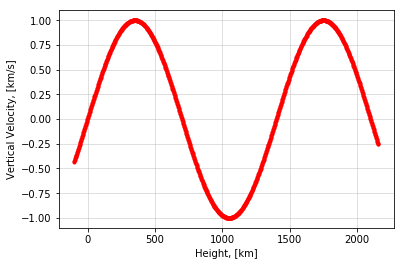

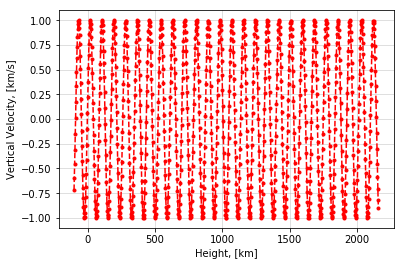

In [24]:
FALC = Atmos_height(atmos_dir+model_name,1000)
#FALC.plot_v_field()
#FALC.plot_T()
FALC.include_V_wave(5e-3,0,1)
FALC.plot_v_field()
FALC.plot_T()
FALC.plot_Ne()
FALC.include_V_wave(8e-2,.1,1)
FALC.plot_v_field()

## Write out the atmospheres ot a RH output

In [25]:
FALC = Atmos_height(atmos_dir+model_name,1000)
FALC.write_TF_test(2e-3,8e-2,30,50,4)

Atmosphere loaded


'Successfully written out atmosphere'

## Analyze the data 

In [119]:
Ha = Spectral_Line('/Users/molnarad/Desktop/rh/results/rh_spect.fits',2e-3,8e-2,30,50,1,656.28)
Ha.Instrument_degrade(IBIS)
Ha.find_lc_min1(False)
for i in range(Ha.N_nu):
    print("For frequency %f"%Ha.nu[i],np.amax(np.abs(Ha.vel_lc[i,:])/3))

For Frequency 0.002000 the degradation is over 1 frames
For Frequency 0.002271 the degradation is over 1 frames
For Frequency 0.002579 the degradation is over 1 frames
For Frequency 0.002929 the degradation is over 1 frames
For Frequency 0.003327 the degradation is over 1 frames
For Frequency 0.003778 the degradation is over 1 frames
For Frequency 0.004290 the degradation is over 1 frames
For Frequency 0.004872 the degradation is over 1 frames
For Frequency 0.005533 the degradation is over 1 frames
For Frequency 0.006284 the degradation is over 1 frames
For Frequency 0.007136 the degradation is over 1 frames
For Frequency 0.008104 the degradation is over 1 frames
For Frequency 0.009203 the degradation is over 1 frames
For Frequency 0.010452 the degradation is over 1 frames
For Frequency 0.011870 the degradation is over 2 frames
For Frequency 0.013480 the degradation is over 2 frames
For Frequency 0.015308 the degradation is over 2 frames
For Frequency 0.017385 the degradation is over 3

In [124]:
Ha = Spectral_Line('/Users/molnarad/Desktop/rh/results/rh_spect.fits',2e-3,8e-2,30,50,1,854.2)
Ha.Instrument_degrade(IBIS)
Ha.find_lc_min1(False)
for i in range(Ha.N_nu):
    print("For frequency %f"%Ha.nu[i],np.amax(np.abs(Ha.vel_lc[i,:])/3))

For Frequency 0.002000 the degradation is over 1 frames
For Frequency 0.002271 the degradation is over 1 frames
For Frequency 0.002579 the degradation is over 1 frames
For Frequency 0.002929 the degradation is over 1 frames
For Frequency 0.003327 the degradation is over 1 frames
For Frequency 0.003778 the degradation is over 1 frames
For Frequency 0.004290 the degradation is over 1 frames
For Frequency 0.004872 the degradation is over 1 frames
For Frequency 0.005533 the degradation is over 1 frames
For Frequency 0.006284 the degradation is over 1 frames
For Frequency 0.007136 the degradation is over 1 frames
For Frequency 0.008104 the degradation is over 1 frames
For Frequency 0.009203 the degradation is over 1 frames
For Frequency 0.010452 the degradation is over 1 frames
For Frequency 0.011870 the degradation is over 2 frames
For Frequency 0.013480 the degradation is over 2 frames
For Frequency 0.015308 the degradation is over 2 frames
For Frequency 0.017385 the degradation is over 3

In [120]:
IBIS = Instrument_Profile(3.5,[0])
#Ha.find_lc_min1(False)

max_vel = np.zeros((Ha.N_nu))
ratio   = np.zeros((Ha.N_nu))
#plt.plot(Ha.vel_lc[0,:])
plt.plot(Ha.vel_lc[6,:])
plt.plot(Ha.vel_lc[-1,:])

plt.show()
for xx in range(Ha.N_nu):
    max_vel[xx] =  np.amax(Ha.vel_lc[xx,:])/1

plt.plot(Ha.nu,max_vel)
plt.grid()
plt.xscale('log')
plt.show()

In [121]:
max_vel = np.zeros((Ha.N_nu))
ratio   = np.zeros((Ha.N_nu))
#Ha.find_lc_min(False)
plt.figure(figsize=(10,6),dpi=200)
i1 = -1
i2 = -10
plt.plot(Ha.vel_lc[i1,:],'b--',label=Ha.nu[i1])
plt.plot(Ha.vel_lc[i1,:],'b.')
plt.plot(Ha.vel_lc[i2,:],'y--',label=Ha.nu[i2])
plt.plot(Ha.vel_lc[i2,:],'y.')
#Ha.Instrument_degrade(IBIS)
#Ha.find_lc_min1(False) 


plt.grid()
plt.legend()
plt.show()
for xx in range(Ha.N_nu):
    max_vel[xx] = (np.amax(Ha.vel_lc[xx,:])-np.amin(Ha.vel_lc[xx,:]))/6

plt.plot(1/Ha.nu,max_vel,'r.')
plt.xscale('log')
plt.grid()
plt.show()

In [123]:
Ha.calc_T()
print(1/Ha.T**2)
Ha.calc_Acoustic_flux(10e6,-1.5)
Ha.flux

[1.03962255e+00 1.16809264e+00 1.15377791e+00 1.21420204e+00
 1.34841733e+00 1.50195968e+00 1.64401439e+00 2.75972524e+00
 3.61631542e+00 5.00720368e+00 6.78347588e+00 9.26986781e+00
 1.14709113e+01 1.28777326e+01 1.16964892e+01 1.16054663e+01
 1.12951145e+01 7.33900175e+01 2.13753742e+01 2.80459042e+01
 5.04692803e+01 5.04692803e+01 7.05944658e+01 2.35010693e+02
 2.47885640e+02 2.23113373e+02 4.77218590e+02 6.60510159e+02
 4.77218590e+02 4.88671836e+03]


(671.4582000033575, 0.5967820054035616)

### Integrate the total acoustic(?) flux

In [ ]:
T = 